In [156]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

%matplotlib inline

In [55]:
# Ramping with I
ISIs = [0.4] * 4
ISI_pts = np.cumsum(ISIs)

# Constants
I0 = 1.5
beta = 3.0
alpha = 1.0

# Initialize
IS = I0
IP = I0
y0 = 0.7

# For storage
yS_lst = []
IS_lst = []
IP_lst = []
productions = []

# Synchronization
for i in range(len(ISIs)):
    print('iteration #', i, 'current ISI = ', ISI_pts[i])
    # Period adjustment
    yS = IS * ISIs[i]
    IS_new = IS - beta * (yS - y0)
    print('yS = ', yS, 'IS_new = ', IS_new)
    yS_lst.append(yS)
    IS_lst.append(IS_new)
    
    # Make production
    tp = y0 / IP
    productions.append(tp)
    print('tp =  ', tp)
    
    # Phase adjustments
    # Calculate y_out of SAM
    if i == 0:
        y_out = IS_new * (np.sum(productions)) # Assume ISI_pts[i-1] = 0 here
    else:
        if ISI_pts[i] < np.sum(productions):
            y_out = IS_new * (np.sum(productions) - ISI_pts[i-1])
        else:
            y_out = IS_new * (np.sum(productions) - ISI_pts[i-1])
    
    print('y_out = ', y_out)
    
    IP = IS_new - alpha * (y0 - y_out)
    IS = IS_new
    IP_lst.append(IP)
    print('IP = ', IP)
    
    
    
# Continuation
n_continuation = 5
yS_inf = 1.0
for i in range(n_continuation):
    # Period adjustment: IS unchanged since no stimulus is observed
    yout = yS_inf
    
    # Make production
    tp = y0 / IP
    productions.append(tp)
    print('tp =  ', tp)
    
    # Phase adjustments
    IP = IS - alpha * (y0 - yout)
    IP_lst.append(IP)
    print('IP = ', IP)
    

    








iteration # 0 current ISI =  0.4
yS =  0.6000000000000001 IS_new =  1.7999999999999996
tp =   0.4666666666666666
y_out =  0.84
IP =  1.94
iteration # 1 current ISI =  0.8
yS =  0.7199999999999999 IS_new =  1.7399999999999998
tp =   0.360824742268
y_out =  0.743835051546
IP =  1.78383505155
iteration # 2 current ISI =  1.2
yS =  0.696 IS_new =  1.7519999999999998
tp =   0.392412964076
y_out =  0.735672461515
IP =  1.78767246151
iteration # 3 current ISI =  1.6
yS =  0.7008 IS_new =  1.7495999999999996
tp =   0.391570612106
y_out =  0.71991663396
IP =  1.76951663396
tp =   0.395588256457
IP =  2.0496
tp =   0.34153005464480873
IP =  2.0496
tp =   0.34153005464480873
IP =  2.0496
tp =   0.34153005464480873
IP =  2.0496
tp =   0.34153005464480873
IP =  2.0496


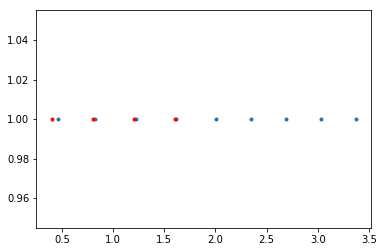

In [56]:
# Plot the result
plt.plot(np.cumsum(productions), np.ones(len(productions)), '.')
plt.plot(ISI_pts, np.ones(len(ISI_pts)) * 1.0, 'r.')

## Discrete updating algorithm

### Continuous time definitions
$y_{\textrm{ref}}$ : Reference level

$y_{\textrm{SAM}}$ : Output of SAM

$y_{\textrm{MPM}}$ : Output of of MPM

$I_{\textrm{SAM}}$ : Input to SAM

$I_{\textrm{MPM}}$ : Input to MPM


### Translation into discrete time
$i$ will index *time-points* and *intervals*

$t_p^i$ : time of $i$th production

$t_s^i$ : time of $i$th stimulus

$\textrm{ISI}^i$ = $t_s^{i+1} - t_s^i$

$\textrm{IPI}^i$ = $t_p^{i+1} - t_p^i$

$y_{\textrm{SAM}}^i=I_{\textrm{SAM}}^i*\textrm{ISI}^i$

$I_{\textrm{SAM}}^{i+1}=I_{\textrm{SAM}}^i+\beta(y_{\textrm{ref}}-y_{\textrm{SAM}}^i)$

$I_{\textrm{MPM}}^{i+1} = I_{\textrm{SAM}}^{i+1} + \alpha(y_{\textrm{out}}^i-y_{\textrm{MPM}}^i)$

$\textrm{IPI}^i=y_{\textrm{ref}}/I_{\textrm{MPM}}$

$t_p^{i+1}=t_p^i+\textrm{IPI}^i$

By definition $y_{\textrm{MPM}}^i=y_{\textrm{ref}}$ (output of $y_{\textrm{MPM}}$ at ith production)

The value of $y_{\textrm{out}}^i$ represents the output of the SAM at the time of the $i$th production. During synchronization that will be:

if $t_s^{i}<t_p^i$

$y_{\textrm{out}}^i = I_{\textrm{SAM}}^i*(t_p^{i}-t_s^{i})$

else

$y_{\textrm{out}}^i = I_{\textrm{SAM}}^i*(t_p^i-t_s^{i-1})$


During continuation:

$y_{\textrm{out}}^i = y_{\textrm{SAM}}^\infty$

with $y_{\textrm{SAM}}^\infty$ representing the terminal output of the SAM module.

In [57]:
# Definitions
def I_s_update(I_s_in,beta,y_ref,y_s):
    I_s_out = I_s_in + beta*(y_ref - y_s)
    
    return I_s_out

def I_p_update(I_s,alpha,y_p,y_out):
    I_p_out = I_s + alpha*(y_out-y_p)
    
    return I_p_out

def discreteAlgorithm(ISI, beta=0.5, alpha=0.1, y_ref=1, I_s_init=0.8, y_s_infty=1.5):

    t_s = np.zeros(len(ISI)+1)
    t_s[1:len(ISI)+1] = np.cumsum(ISI)
    IPI = np.zeros((len(t_s)))
    t_p = np.zeros((len(t_s)))
    I_s = np.zeros((len(t_s)))
    I_p = np.zeros((len(t_s)))
    y_s = np.zeros((len(t_s)))
    I_p[0] = I_s_init
    I_s[0] = I_s_init

    for i in range(len(ISI)):

        IPI[i] = y_ref/I_p[i]
        if i > 0:
            t_p[i+1] = t_p[i] + IPI[i]
        else:
            t_p[i+1] = IPI[i]
        
        if np.isnan(ISI[i]):
            y_s[i] = y_s_infty
            I_s[i+1] = I_s[i]
        else:
            y_s[i] = I_s[i]*ISI[i]
            I_s[i+1] = I_s_update(I_s[i],beta,y_ref,y_s[i])

        
        if np.isnan(ISI[i]):
            y_out = y_s_infty
        else:
            if t_s[i] < t_p[i]:
                y_out = I_s[i]*(t_p[i]-t_s[i])
            else:
                if i == 0:
                    y_out = y_ref
                else:
                    y_out = I_s[i]*(t_p[i]-t_s[i-1])
                #print(i,y_out)


        I_p[i+1] = I_p_update(I_s[i+1],alpha,y_ref,y_out)
        #print(t_s[i],t_p[i],IPI[i])
    
    return t_s, t_p, IPI, I_s, I_p, y_s

def discreteAlgorithm_modified(ISI, beta=0.5, alpha=0.1, y_ref=1, I_s_init=0.8):

    t_s = np.zeros(len(ISI)+1)
    t_s[1:len(ISI)+1] = np.cumsum(ISI)
    IPI = np.zeros((len(t_s)))
    t_p = np.zeros((len(t_s)))
    I_s = np.zeros((len(t_s)))
    I_p = np.zeros((len(t_s)))
    y_s = np.zeros((len(t_s)))
    I_p[0] = I_s_init
    I_s[0] = I_s_init

    for i in range(len(ISI)):

        IPI[i] = y_ref/I_p[i]
        if i > 0:
            t_p[i+1] = t_p[i] + IPI[i]
        else:
            t_p[i+1] = IPI[i]

        y_s[i] = I_s[i]*ISI[i]
        #print('i = ', i,'y_s = ', y_s[i], 'I_s = ', I_s[i])

        I_s[i+1] = I_s_update(I_s[i],beta,y_ref,y_s[i])

        if t_s[i] < t_p[i]:
            y_out = I_s[i]*(t_p[i]-t_s[i-1])
        else:
            if i == 0:
                y_out = y_ref
            else:
                y_out = I_s[i]*(t_p[i]-t_s[i-1])
            #print(i,y_out)


        #print('yout = ', y_out)
        I_p[i+1] = I_p_update(I_s[i+1],alpha,y_ref,y_out)
        #print(t_s[i],t_p[i],IPI[i])
    
    return t_s, t_p, IPI, I_s, I_p, y_s

## Synchronization to a constant ISI

### Algorithm with $t_p[i]-t_s[i]$ and $t_p[i]-t_s[i-1]$

In [58]:
# Simple synchronization
ISI_short = [0.5] * 10
ISI_long = [0.7] * 10

t_s1, t_p1, IPI1, _, _, _ = discreteAlgorithm(ISI_short, beta=2.0, alpha=0.1, y_ref=1, I_s_init=1/0.6)
t_s2, t_p2, IPI2, _, _, _ = discreteAlgorithm(ISI_long, beta=2.0, alpha=0.1, y_ref=1, I_s_init=1/0.6)



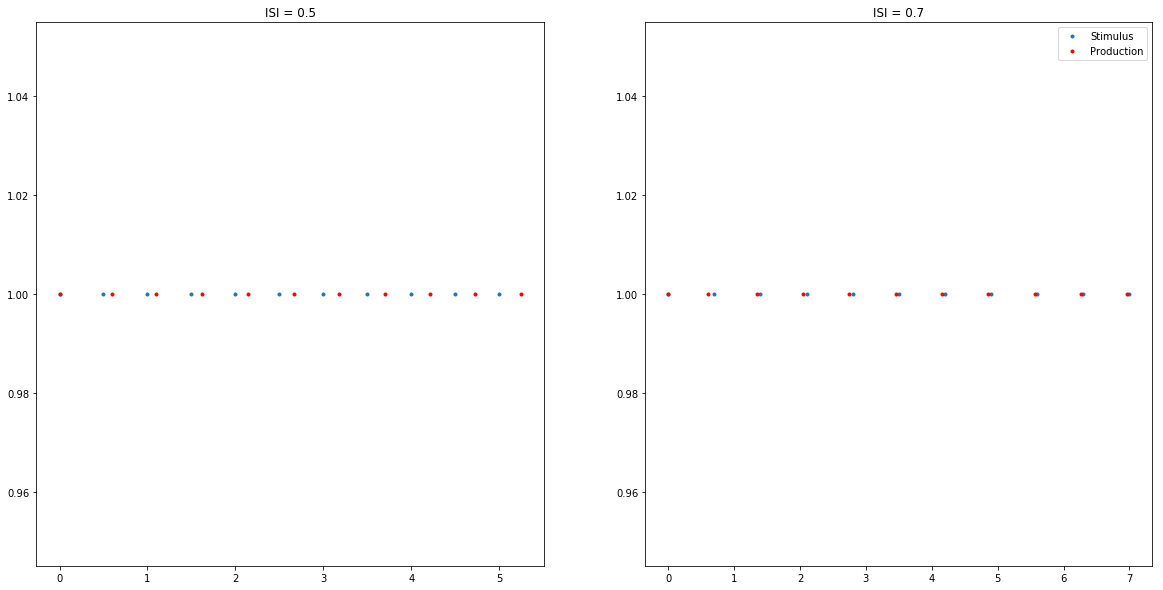

In [59]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(t_s1, np.ones(len(t_s1)), '.')
plt.plot(t_p1, np.ones(len(t_s1)),'r.')
plt.title('ISI = 0.5')

plt.subplot(122)
plt.plot(t_s2, np.ones(len(t_s2)), '.')
plt.plot(t_p2, np.ones(len(t_s2)),'r.')
plt.title('ISI = 0.7')
plt.legend(['Stimulus', 'Production'])

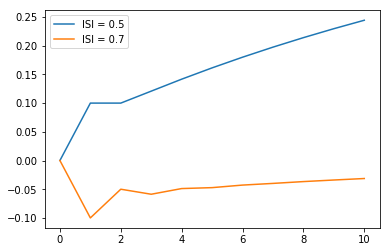

In [60]:
plt.plot(t_p1-t_s1)
plt.plot(t_p2 - t_s2)
plt.legend(['ISI = 0.5', 'ISI = 0.7'])

### Algorithm with $t_p[i]-t_s[i-1]$ only

In [61]:
# Simple synchronization
ISI_short = [0.5] * 10
ISI_long = [0.7] * 10

t_s1, t_p1, IPI1, _, _, _ = discreteAlgorithm_modified(ISI_short, beta=2.0, alpha=0.1, y_ref=1, I_s_init=1/0.6)
t_s2, t_p2, IPI2, _, _, _ = discreteAlgorithm_modified(ISI_long, beta=2.0, alpha=0.1, y_ref=1, I_s_init=1/0.6)

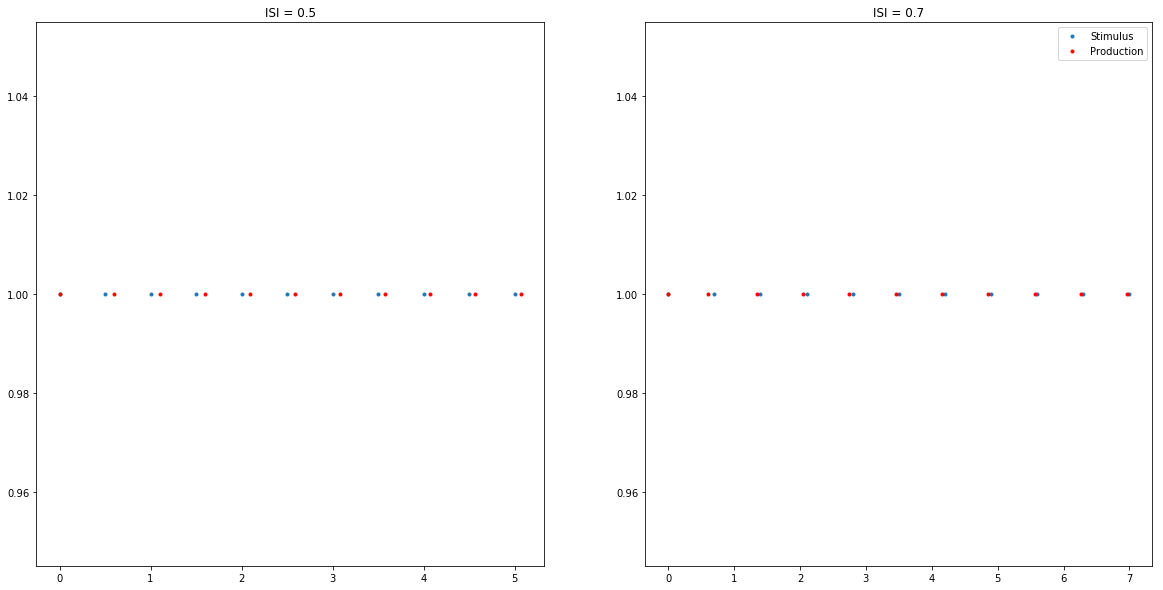

In [62]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(t_s1, np.ones(len(t_s1)), '.')
plt.plot(t_p1, np.ones(len(t_s1)),'r.')
plt.title('ISI = 0.5')

plt.subplot(122)
plt.plot(t_s2, np.ones(len(t_s2)), '.')
plt.plot(t_p2, np.ones(len(t_s2)),'r.')
plt.title('ISI = 0.7')
plt.legend(['Stimulus', 'Production'])

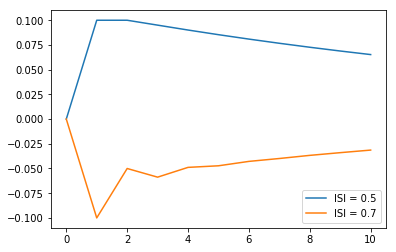

In [63]:
plt.plot(t_p1-t_s1)
plt.plot(t_p2 - t_s2)
plt.legend(['ISI = 0.5', 'ISI = 0.7'])

In [278]:
# Definitions
def I_s_update(I_s_in,beta,y_ref,y_s):
    I_s_out = I_s_in + beta*(y_ref - y_s)
    
    return I_s_out

def I_p_update(I_s,alpha,y_p,y_out):
    I_p_out = I_s + alpha*(y_out-y_p)
    
    return I_p_out

def discreteAlgorithm(ISI, beta=0.5, alpha=0.1, y_ref=1, I_s_init=0.8, y_s_infty=1.5):

    t_s = np.zeros(len(ISI)+1)
    t_s[1:len(ISI)+1] = np.cumsum(ISI)
    IPI = np.zeros((len(t_s)))
    t_p = np.zeros((len(t_s)))
    I_s = np.zeros((len(t_s)))
    I_p = np.zeros((len(t_s)))
    y_s = np.zeros((len(t_s)))
    I_p[0] = I_s_init
    I_s[0] = I_s_init

    for i in range(len(ISI)):

        IPI[i] = y_ref/I_p[i]
        if i > 0:
            t_p[i+1] = t_p[i] + IPI[i]
        else:
            t_p[i+1] = IPI[i]
        
        if np.isnan(ISI[i]):
            y_s[i] = y_s_infty
            I_s[i+1] = I_s[i]
        else:
            y_s[i] = I_s[i]*ISI[i]
            I_s[i+1] = I_s_update(I_s[i],beta,y_ref,y_s[i])

        
        if np.isnan(ISI[i]):
            y_out = y_s_infty
        else:
            if i == 0:
                y_out = y_ref
            else:
                y_out = I_s[i]*(t_p[i]-t_s[i-1])
            #print(i,y_out)

        # Standard code for algorithm, implementing integration of differences over time
        I_p[i+1] = I_p_update(I_s[i+1],alpha,y_ref,y_out)
        
        # Code that does not integrate differences over time
        #if np.isnan(t_s[i]):
        #    I_p[i+1] = I_p_update(I_s[i+1],alpha,t_p[i],t_p[i]+0.4)
        #else:       
        #    I_p[i+1] = I_p_update(I_s[i+1],alpha,t_p[i],t_s[i])
        
        #print(t_s[i],t_p[i],IPI[i])
    
    return t_s, t_p, IPI, I_s, I_p, y_s

## Synchronization to a constant ISI

In [279]:
# Simple synchronization
ISI = [0.4] * 500
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.2, alpha=0.1, y_ref=1, I_s_init=1/0.35)

#for i in range(len(t_s)):
#    print(t_s[i],t_p[i],IPI[i])

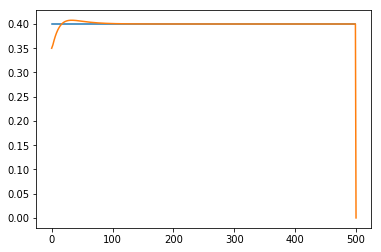

In [280]:
plt.plot(ISI)
plt.plot(IPI)

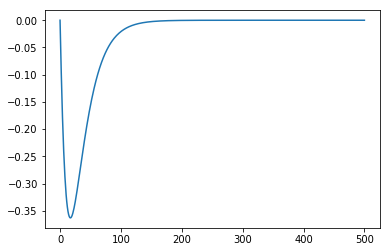

In [281]:
plt.plot(t_p-t_s)

## Step Change

In [282]:
# Step change
ISI = np.concatenate((0.80*np.ones(100),1.00*np.ones(30)))
del t_p
del t_s
del IPI
del I_s
del I_p
del y_s
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.5, alpha=0.1, y_ref=1, I_s_init=1/0.8)

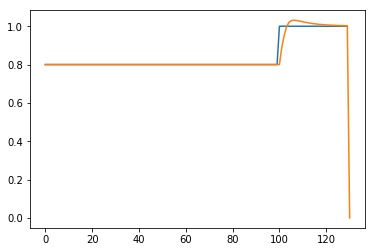

In [283]:
plt.plot(ISI)
plt.plot(IPI)

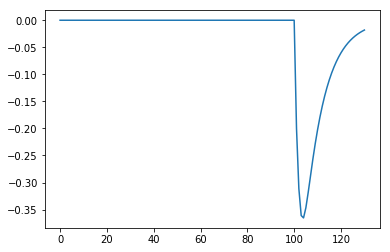

In [284]:
plt.plot(t_p-t_s)

## Phase shift

In [285]:
# Phase shift
ISI = np.concatenate((0.80*np.ones(50),0.9*np.ones(1),0.80*np.ones(50)))
del t_p
del t_s
del IPI
del I_s
del I_p
del y_s
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.7, alpha=0.1, y_ref=1, I_s_init=1/0.8)

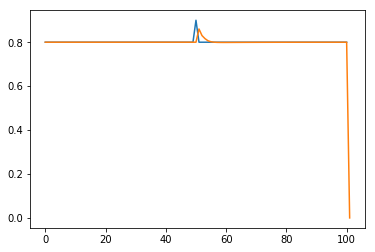

In [286]:
plt.plot(ISI)
plt.plot(IPI)

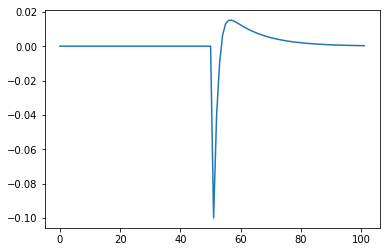

In [287]:
plt.plot(t_p-t_s)

## Stimulus jitter

In [288]:
# Stimulus jitter
ISI = np.concatenate((0.80*np.ones(50),0.9*np.ones(1), 0.7*np.ones(1), 0.80*np.ones(49)))
del t_p
del t_s
del IPI
del I_s
del I_p
del y_s
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.7, alpha=0.1, y_ref=1, I_s_init=1/0.8)

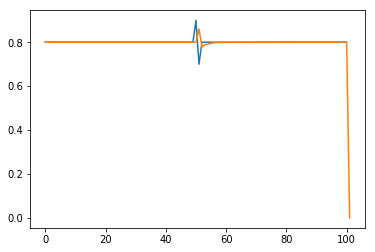

In [289]:
plt.plot(ISI)
plt.plot(IPI)

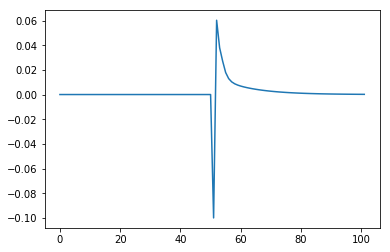

In [290]:
plt.plot(t_p-t_s)

## 1-2-Go, 1-2-3-Go

In [291]:
# 1-2-Go, 1-2-3-Go
ISIs = np.linspace(0.600,1.000,num=5)
print(ISIs)
ISI_list = np.nan*np.ones((len(ISIs),3))
IPI_list = np.nan*np.ones((len(ISIs),4))
t_s_list = []
t_p_list = []
for i in range(len(ISIs)):
    ISI_list[i,:] = ISIs[i]*np.ones(3)
    del t_p
    del t_s
    del IPI
    del I_s
    del I_p
    del y_s
    ISI = ISI_list[i,:]
    t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.75, alpha=0.0, y_ref=1, I_s_init=1/0.8)
    
    t_s_list.append(t_s)
    t_p_list.append(t_p)
    IPI_list[i,:] = IPI

[ 0.6  0.7  0.8  0.9  1. ]


In [292]:
tempISIs = np.matlib.repmat(ISIs,4,1)
sqErrs = np.square(IPI_list - np.transpose(tempISIs))
sqBIAS = sqErrs.sum(axis=0)/len(ISIs)
print(sqBIAS)

[  2.00000000e-02   3.15928608e-03   6.39298339e-04   6.60000000e-01]


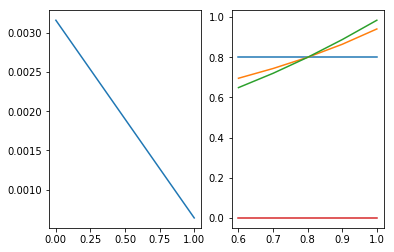

In [293]:
plt.subplot(121)
plt.plot(sqBIAS[1:3])

plt.subplot(122)
plt.plot(np.transpose(tempISIs),IPI_list)

## Synchronization/continuation

In [294]:
# Synchronization/continuation
ISIs = np.linspace(0.550,0.817,num=5)
print(ISIs)
ISI_list = np.nan*np.ones((len(ISIs),12))
IPI_list = np.nan*np.ones((len(ISIs),13))
t_s_list = []
t_p_list = []
for i in range(len(ISIs)):
    ISI_list[i,:] = np.concatenate((ISIs[i]*np.ones(4),np.nan*np.ones(8)))
    del t_p
    del t_s
    del IPI
    del I_s
    del I_p
    del y_s
    ISI = ISI_list[i,:]
    t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.75, alpha=0.1, y_ref=1, I_s_init=1/0.6835, y_s_infty=1.5)
    
    t_s_list.append(t_s)
    t_p_list.append(t_p)
    IPI_list[i,:] = IPI

[ 0.55     0.61675  0.6835   0.75025  0.817  ]


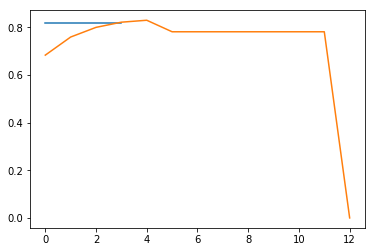

In [295]:
plt.plot(ISI)
plt.plot(IPI)

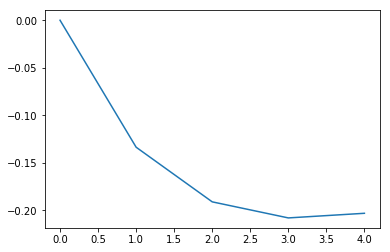

In [296]:
plt.plot(t_p-t_s)

In [297]:
tempISIs = np.matlib.repmat(ISIs,13,1)
sqErrs = np.square(IPI_list - np.transpose(tempISIs))
sqBIAS = sqErrs.sum(axis=0)/len(ISIs)
print(sqBIAS)

[  8.91112500e-03   2.09892614e-03   3.95389908e-04   4.58888671e-05
   3.99369634e-05   5.65980556e-04   5.65980556e-04   5.65980556e-04
   5.65980556e-04   5.65980556e-04   5.65980556e-04   5.65980556e-04
   4.76083375e-01]


(13, 5)


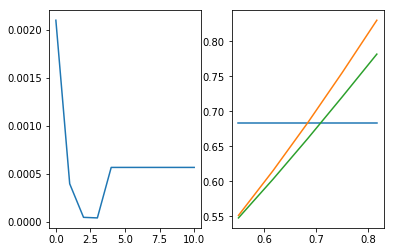

In [298]:
plt.subplot(121)
plt.plot(sqBIAS[1:12])

plt.subplot(122)
print(tempISIs.shape)
plt.plot(np.transpose(tempISIs[(0,4,10),:]),IPI_list[:,(0,4,10)])